In [69]:
!pip install wget
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install tqdm
!pip install xgboost
!pip install --upgrade ipywidgets

In [70]:
import pandas as pd
import wget
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from tqdm.auto import tqdm
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from matplotlib.colors import LinearSegmentedColormap

%matplotlib inline

In [71]:
url =  'https://raw.githubusercontent.com/Veranika23/endometriosis-prediction/refs/heads/main/data/structured_endometriosis_data.csv'

In [72]:
downloaded_file = wget.download(url)

100% [.............................................] 418095 / 418095

In [73]:
df = pd.read_csv(downloaded_file)

## EDA

In [74]:
df.head()

,Age,Menstrual_Irregularity,Chronic_Pain_Level,Hormone_Level_Abnormality,Infertility,BMI,Diagnosis,Physical_activity
0,24,1,8.361531,0,0,19.451314,0,Never
1,37,1,4.995508,0,0,22.388436,0,Often
2,46,1,3.363996,1,0,21.320443,0,Never
3,32,1,5.246037,0,0,20.177715,1,Often
4,28,1,3.898932,1,0,23.538103,1,Never


In [75]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [76]:
df.head()

,age,menstrual_irregularity,chronic_pain_level,hormone_level_abnormality,infertility,bmi,diagnosis,physical_activity
0,24,1,8.361531,0,0,19.451314,0,Never
1,37,1,4.995508,0,0,22.388436,0,Often
2,46,1,3.363996,1,0,21.320443,0,Never
3,32,1,5.246037,0,0,20.177715,1,Often
4,28,1,3.898932,1,0,23.538103,1,Never


In [77]:
df.isnull().sum()

age                          0
menstrual_irregularity       0
chronic_pain_level           0
hormone_level_abnormality    0
infertility                  0
bmi                          0
diagnosis                    0
physical_activity            0
dtype: int64

In [78]:
df.dtypes

age                            int64
menstrual_irregularity         int64
chronic_pain_level           float64
hormone_level_abnormality      int64
infertility                    int64
bmi                          float64
diagnosis                      int64
physical_activity             object
dtype: object

### Checking if the model is balanced

In [79]:
df.diagnosis.value_counts()

diagnosis
0    5921
1    4079
Name: count, dtype: int64

In [80]:
df.diagnosis.mean()

np.float64(0.4079)

The target is balanced

In [81]:
numerical_columns = list(df.dtypes[(df.dtypes == 'int64') | (df.dtypes == 'float64')].index)

In [82]:
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

In [83]:
print(f"Numerical columns are: {numerical_columns}")

Numerical columns are: ['age', 'menstrual_irregularity', 'chronic_pain_level', 'hormone_level_abnormality', 'infertility', 'bmi', 'diagnosis']


In [84]:
print(f"Categorical columns are: {categorical_columns}")

Categorical columns are: ['physical_activity']


In [85]:
for c in categorical_columns:
    df[c] = df[c].replace("_", " ").str.lower()

In [86]:
df.head()

,age,menstrual_irregularity,chronic_pain_level,hormone_level_abnormality,infertility,bmi,diagnosis,physical_activity
0,24,1,8.361531,0,0,19.451314,0,never
1,37,1,4.995508,0,0,22.388436,0,often
2,46,1,3.363996,1,0,21.320443,0,never
3,32,1,5.246037,0,0,20.177715,1,often
4,28,1,3.898932,1,0,23.538103,1,never


In [87]:
df.describe().round(0)

,age,menstrual_irregularity,chronic_pain_level,hormone_level_abnormality,infertility,bmi,diagnosis
count,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0,10000.0
mean,34.0,1.0,5.0,1.0,0.0,23.0,0.0
std,9.0,0.0,2.0,0.0,0.0,4.0,0.0
min,18.0,0.0,0.0,0.0,0.0,15.0,0.0
25%,26.0,0.0,4.0,0.0,0.0,20.0,0.0
50%,34.0,1.0,5.0,1.0,0.0,23.0,0.0
75%,42.0,1.0,6.0,1.0,1.0,26.0,1.0
max,49.0,1.0,10.0,1.0,1.0,37.0,1.0


### Correlation

In [88]:
corr = df[numerical_columns].corr()
corr

,age,menstrual_irregularity,chronic_pain_level,hormone_level_abnormality,infertility,bmi,diagnosis
age,1.000000,-0.007918,-0.009348,-0.004070,0.014078,-0.011878,-0.011559
menstrual_irregularity,-0.007918,1.000000,0.000103,0.014647,-0.012202,0.004868,0.095197
chronic_pain_level,-0.009348,0.000103,1.000000,0.002467,0.009299,0.005755,0.116996
hormone_level_abnormality,-0.004070,0.014647,0.002467,1.000000,0.003890,-0.015499,0.187039
infertility,0.014078,-0.012202,0.009299,0.003890,1.000000,0.011529,0.096172
bmi,-0.011878,0.004868,0.005755,-0.015499,0.011529,1.000000,0.080310
diagnosis,-0.011559,0.095197,0.116996,0.187039,0.096172,0.080310,1.000000


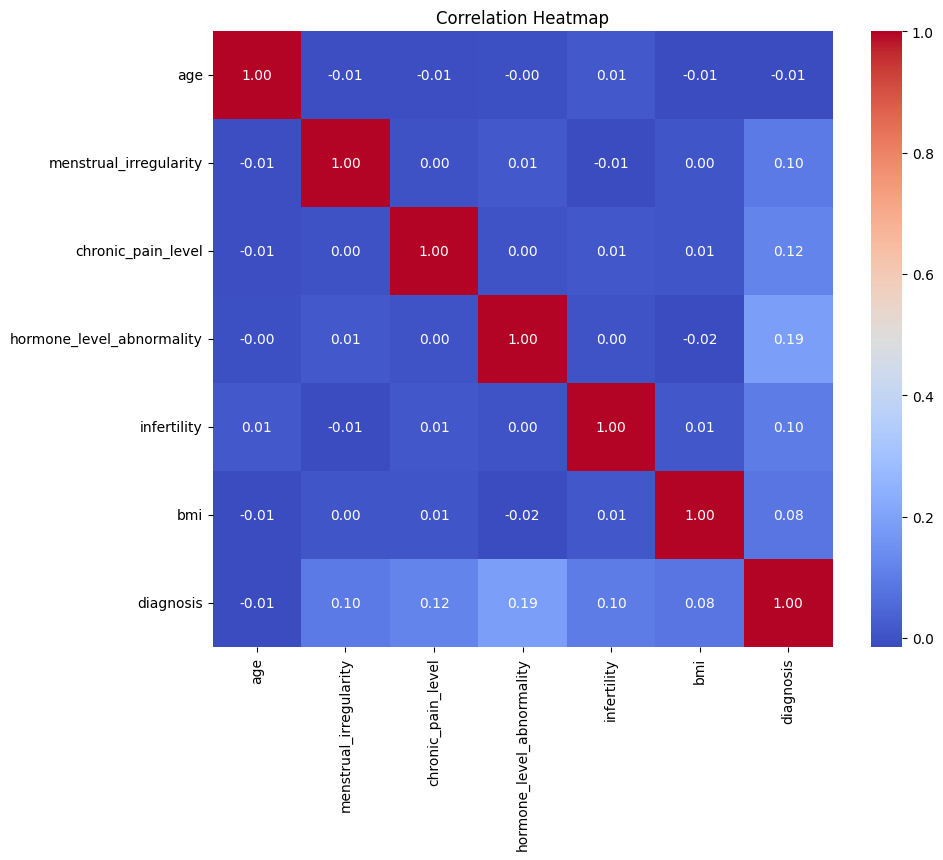

In [89]:
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

Target variable has the highest positive correlation with chronic pain level and hormone level abnormality. Age has no correlation with endometriosis diagnosis. Thus, we are removing it from the model.

In [91]:
del df['age']

### Mutual Information

In [92]:
def mutual_info_converted_score (series):
    return mutual_info_score(series, df.diagnosis.values)

In [93]:
mi = df[categorical_columns].apply(mutual_info_converted_score)
mi.sort_values(ascending = False).to_frame(name= 'mutual information')

,mutual information
physical_activity,0.000284


## Logistic regression with Scikit-Learn

In [94]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)

In [95]:
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 42)

In [96]:
df_train.reset_index(drop = True)
df_val.reset_index(drop = True)
df_test.reset_index(drop = True)

,menstrual_irregularity,chronic_pain_level,hormone_level_abnormality,infertility,bmi,diagnosis,physical_activity
0,1,2.303931,1,1,19.128951,0,often
1,1,2.748098,1,0,24.036195,0,never
2,0,3.592687,1,0,25.939358,1,often
3,1,6.280112,0,0,17.421034,1,rarely
4,1,5.704050,0,0,20.698456,0,often
...,...,...,...,...,...,...,...
1995,0,4.277071,1,1,20.191541,0,often
1996,1,5.313937,1,0,15.425114,0,never
1997,1,9.234746,1,0,19.243390,0,often
1998,1,5.810480,1,1,21.280473,0,never


In [97]:
y_train = df_train.diagnosis.values
y_val = df_val.diagnosis.values
y_test = df_test.diagnosis.values
y_full_train = df_full_train.diagnosis.values

In [98]:
del df_train['diagnosis']
del df_val['diagnosis']
del df_test['diagnosis']

One-hot encoding

In [99]:
numerical_columns = list(df_train.dtypes[df.dtypes == 'int64'].index)

In [100]:
train_dicts = df_train[categorical_columns + numerical_columns].to_dict(orient = 'records')

In [101]:
val_dicts = df_val[categorical_columns + numerical_columns].to_dict(orient = 'records')

In [102]:
dv = DictVectorizer(sparse=False)

In [103]:
X_train = dv.fit_transform(train_dicts)

In [104]:
X_val = dv.transform(val_dicts)

In [105]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)

In [106]:
model.fit(X_train, y_train)

,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",42
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multi

In [107]:
y_pred = model.predict_proba(X_val)[:,1]
(y_val == (y_pred >= 0.5)).mean()

np.float64(0.608)

In [108]:
roc_auc_score(y_val, y_pred)

0.623184125691299

### Tuning the C parameter

In [109]:
scores = {}
for C in [0.001, 0.01, 0.1, 0.5, 1, 5, 10]:
    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state = 42)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:,1]
    auc_score = roc_auc_score(y_val, y_pred)
    scores[C] = round(auc_score, 5)
    print(f"C = {C}: \t roc_auc_score = {round(auc_score, 5)}")

C = 0.001: 	 roc_auc_score = 0.59398
C = 0.01: 	 roc_auc_score = 0.62031
C = 0.1: 	 roc_auc_score = 0.62267
C = 0.5: 	 roc_auc_score = 0.62318
C = 1: 	 roc_auc_score = 0.62318
C = 5: 	 roc_auc_score = 0.62318
C = 10: 	 roc_auc_score = 0.62318


In [110]:
scores

{0.001: 0.59398,
 0.01: 0.62031,
 0.1: 0.62267,
 0.5: 0.62318,
 1: 0.62318,
 5: 0.62318,
 10: 0.62318}

In [111]:
print(f"The best C parameter is {max(scores, key = scores.get)}")

The best C parameter is 0.5


Training the final model for Logistic Regression

In [42]:
del df_full_train['diagnosis']

In [112]:
def train(df_train, y_train, C=0.5):
    dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [113]:
def predict(df, dv, model):
    dicts = df[categorical_columns + numerical_columns].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [114]:
dv, model = train(df_full_train, y_full_train, C=0.5)
y_pred = predict(df_test, dv, model)

logistic_auc = roc_auc_score(y_test, y_pred)

In [115]:
logistic_auc

0.6435492854140396

## Decision Tree

In [116]:
df_full_train, df_test = train_test_split(df, test_size = 0.2, random_state = 42)
df_train, df_val = train_test_split(df_full_train, test_size = 0.25, random_state = 42)

In [117]:
df_train.reset_index(drop = True)
df_val.reset_index(drop = True)
df_test.reset_index(drop = True)

,menstrual_irregularity,chronic_pain_level,hormone_level_abnormality,infertility,bmi,diagnosis,physical_activity
0,1,2.303931,1,1,19.128951,0,often
1,1,2.748098,1,0,24.036195,0,never
2,0,3.592687,1,0,25.939358,1,often
3,1,6.280112,0,0,17.421034,1,rarely
4,1,5.704050,0,0,20.698456,0,often
...,...,...,...,...,...,...,...
1995,0,4.277071,1,1,20.191541,0,often
1996,1,5.313937,1,0,15.425114,0,never
1997,1,9.234746,1,0,19.243390,0,often
1998,1,5.810480,1,1,21.280473,0,never


In [118]:
y_train = df_train.diagnosis.values
y_val = df_val.diagnosis.values
y_test = df_test.diagnosis.values
y_full_train = df_full_train.diagnosis.values

In [119]:
del df_train['diagnosis']
del df_val['diagnosis']
del df_test['diagnosis']

In [120]:
train_dicts = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)
val_dicts = df_val.to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [121]:
dt = DecisionTreeClassifier()

In [122]:
dt.fit(X_train, y_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the curre

In [123]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.5391868240502118

### Tuning max_depth

In [124]:
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.580
   2 -> 0.594
   3 -> 0.607
   4 -> 0.616
   5 -> 0.625
   6 -> 0.620
  10 -> 0.566
  15 -> 0.550
  20 -> 0.534
None -> 0.531


Decision Tree with meximum depth of 5 and 6 have the best roc_auc_score

### Tuning min_samples_leaf

In [125]:
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [126]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [127]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.616  0.625  0.620
5                 0.616  0.625  0.621
10                0.616  0.624  0.619
15                0.619  0.626  0.622
20                0.619  0.627  0.621
100               0.621  0.622  0.630
200               0.620  0.624  0.630
500               0.612  0.613  0.613

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

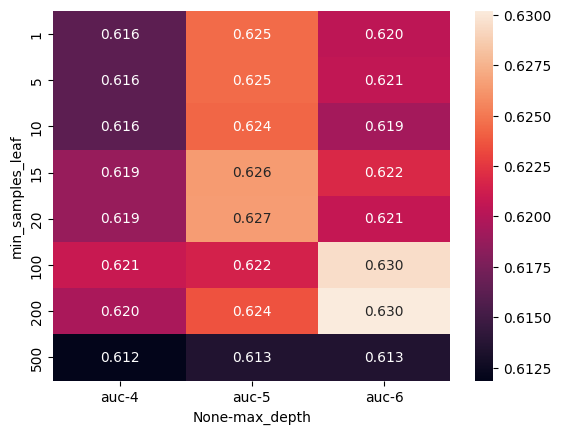

In [128]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

The model with max_depth = 6 and min_samples_leaf = 200 has the best AUC = 0.63

Training the tuned Decision Tree model

In [129]:
test_dicts = df_test.to_dict(orient='records')
X_test = dv.transform(test_dicts)

In [130]:
del df_full_train['diagnosis']

In [131]:
df_full_train.reset_index(drop = True)

,menstrual_irregularity,chronic_pain_level,hormone_level_abnormality,infertility,bmi,physical_activity
0,1,8.347381,1,0,26.450822,rarely
1,1,8.355368,1,1,24.528480,often
2,1,2.141347,1,0,25.289643,never
3,1,4.954645,0,0,16.767964,often
4,0,5.973239,0,0,27.968651,often
...,...,...,...,...,...,...
7995,1,8.312645,0,0,26.524167,rarely
7996,1,5.977040,0,0,19.506356,rarely
7997,1,5.408001,1,0,24.735157,never
7998,1,0.079128,1,0,16.036950,rarely


In [132]:
full_train_dicts = df_full_train.to_dict(orient='records')
X_full_train = dv.transform(full_train_dicts)

In [133]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=200)
dt.fit(X_full_train, y_full_train)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",6
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",200
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",None
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the curren

In [134]:
y_pred = dt.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)

In [135]:
print(auc)

0.6424316939890712


In [136]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- hormone_level_abnormality <= 0.50
|   |--- bmi <= 25.24
|   |   |--- menstrual_irregularity <= 0.50
|   |   |   |--- chronic_pain_level <= 5.27
|   |   |   |   |--- class: 0
|   |   |   |--- chronic_pain_level >  5.27
|   |   |   |   |--- class: 0
|   |   |--- menstrual_irregularity >  0.50
|   |   |   |--- infertility <= 0.50
|   |   |   |   |--- chronic_pain_level <= 3.73
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- chronic_pain_level >  3.73
|   |   |   |   |   |--- chronic_pain_level <= 5.70
|   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- chronic_pain_level >  5.70
|   |   |   |   |   |   |--- class: 0
|   |   |   |--- infertility >  0.50
|   |   |   |   |--- chronic_pain_level <= 4.77
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- chronic_pain_level >  4.77
|   |   |   |   |   |--- class: 0
|   |--- bmi >  25.24
|   |   |--- chronic_pain_level <= 5.86
|   |   |   |--- chronic_pain_level <= 3.94
|   |   |   |   |--- class: 0
|   |   |   |--- ch

## Random Forest

In [137]:
rf = RandomForestClassifier(n_estimators=10,
                            random_state=39,
                            n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)
print("AUC :", round(roc_auc_score(y_val, y_pred), 3))

AUC : 0.535


### Tuning n_estimators

In [138]:
scores = []

for n in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [139]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
df_scores

,n_estimators,auc
0,10,0.566408
1,20,0.576219
2,30,0.577824
3,40,0.577303
4,50,0.575962
5,60,0.576664
6,70,0.575589
7,80,0.578036
8,90,0.577908
9,100,0.576362


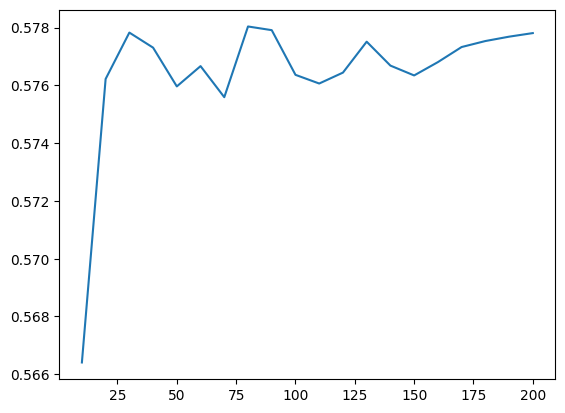

In [140]:
plt.plot(df_scores.n_estimators, df_scores.auc)

### Tuning max_depth

In [141]:
scores = []
for d in [5, 10, 15, 20]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=39,
                                    n_jobs=-1)
        rf.fit(X_train, y_train)
        y_pred = rf.predict(X_val)
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

In [142]:
df_scores = pd.DataFrame(scores, columns=["max_depth", "n_estimators", "auc"])
df_scores

,max_depth,n_estimators,auc
0,5,10,0.567568
1,5,20,0.569598
2,5,30,0.574131
3,5,40,0.565622
4,5,50,0.566725
...,...,...,...
75,20,160,0.550551
76,20,170,0.556154
77,20,180,0.555926
78,20,190,0.554662


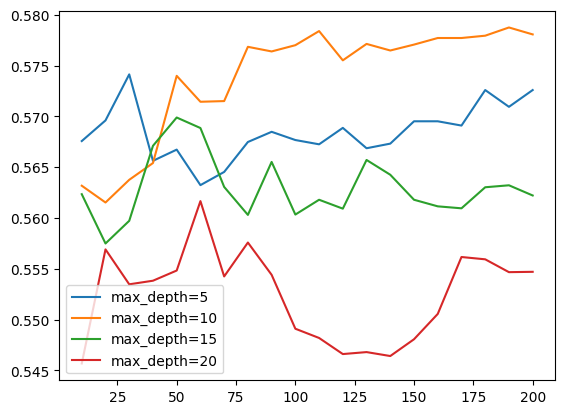

In [143]:
for d in [5, 10, 15, 20]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

In [144]:
max_depth = 10

### Tuning min_samples_leaf

In [145]:
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [146]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.T

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
min_samples_leaf,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.00000,50.000000,50.00000
n_estimators,10.000000,20.000000,30.000000,40.000000,50.000000,60.000000,70.000000,80.000000,90.000000,100.000000,...,110.000000,120.000000,130.000000,140.000000,150.000000,160.000000,170.00000,180.00000,190.000000,200.00000
auc,0.599808,0.604728,0.606433,0.608174,0.607693,0.608594,0.609819,0.610513,0.610256,0.611023,...,0.638009,0.638139,0.638246,0.638079,0.638053,0.638317,0.63829,0.63826,0.637998,0.63781


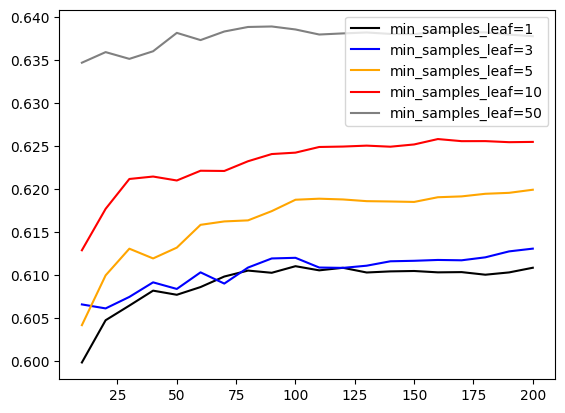

In [147]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [148]:
min_samples_leaf = 50

### Training the tuned Random Forest Model

In [149]:
rf = RandomForestClassifier(n_estimators=80,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_full_train, y_full_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",80
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",50
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y

In [151]:
y_pred = rf.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred)
auc

0.655932639764607

## Gradient Boosting and XGBoost